# FCNs for semantic segmentation

In this exercise we will look at the basics how to build a fully convolutional network for semantic segmentation.

## A first example

In [1]:
# install all needed packages
from typing import Tuple
import numpy as np
import skimage.io
import tensorflow.keras as keras
from keras.utils import to_categorical
from keras import regularizers
from keras.activations import softmax

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
#mpl.rcParams['figure.dpi']= 400

Using TensorFlow backend.


In [2]:
# check tensorflow installation to see if we have GPU support
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10266377771068731634
]


### Load real data
Batch of data
Training is usually done using a batch of data. For semantic segmentation, that will be a batch of image (patches).

In [3]:
nr_of_labels = 47   # n labels   (Global Variabel)

(3, 128, 128, 1) float32 (3, 14884, 47) float32


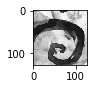

In [23]:
def load_train_batch(n_samples):
    label_list = []
    image_list = []
    for i in range(n_samples):  # Anzahl Validation Bilder
        im = skimage.io.imread('dtd_train/image_' + ('%05d' % i) + '.png')
        im = im.reshape(1, im.shape[0], im.shape[1], 1)
        lab = skimage.io.imread('dtd_train/label_' + ('%05d' % i) + '.png')
        class_id = lab[0,0]
        nr_of_pixels = (im.shape[1]-6)*(im.shape[2]-6)
        
        label = np.concatenate([to_categorical(class_id, nr_of_labels).reshape(1, 1, nr_of_labels)
                                for _ in range(nr_of_pixels)], axis=1)
        label_list.append(label)
        image_list.append(im.astype(np.float32) / 255.0)
    
    labels = np.concatenate([label for label in label_list], axis=0)
    images = np.concatenate([im for im in image_list], axis=0)
    
    return images, labels

#tester:
im, lab = load_train_batch(3)
plt.figure(figsize = (1,1))
plt.imshow(im[0].reshape(128,128), cmap='gray')
print(im.shape, im.dtype,    lab.shape, lab.dtype)

(3, 128, 128, 1) float32 (3, 14884, 47) float32


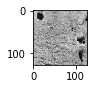

In [5]:
def load_validation_batch(n_samples):
    
    label_list = []
    image_list = []
    for i in range(n_samples):  # Anzahl Validation Bilder
        im = skimage.io.imread('dtd_val/image_' + ('%05d' % i) + '.png')
        im = im.reshape(1, im.shape[0], im.shape[1], 1)
        lab = skimage.io.imread('dtd_val/label_' + ('%05d' % i) + '.png')
        class_id = lab[0,0]
        nr_of_pixels = (im.shape[1]-6)*(im.shape[2]-6)
    
        label = np.concatenate([to_categorical(class_id, nr_of_labels).reshape(1, 1, nr_of_labels) 
                                for _ in range(nr_of_pixels)], axis=1)
        label_list.append(label)
        image_list.append(im.astype(np.float32) / 255.0)
    
    labels = np.concatenate([label for label in label_list], axis=0)
    images = np.concatenate([im for im in image_list], axis=0)
    
    return images, labels

#tester:
im, lab = load_validation_batch(3)
plt.figure(figsize = (1,1))
plt.imshow(im[0].reshape(128,128), cmap='gray')
print(im.shape, im.dtype,    lab.shape, lab.dtype)

(3, 128, 128, 1) float32 (3, 14884, 47) float32


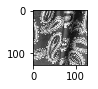

In [6]:
def load_test_batch(n_samples):
    
    label_list = []
    image_list = []
    for i in range(n_samples):  # Anzahl Validation Bilder
        im = skimage.io.imread('dtd_test/image_' + ('%05d' % i) + '.png')
        im = im.reshape(1, im.shape[0], im.shape[1], 1)
        lab = skimage.io.imread('dtd_test/label_' + ('%05d' % i) + '.png')
        class_id = lab[0,0]
        
        width = im.shape[1]
        height = im.shape[2]

        nr_of_pixels = (im.shape[1]-6)*(im.shape[2]-6)
    
        label = np.concatenate([to_categorical(class_id, nr_of_labels).reshape(1, 1, nr_of_labels) 
                                for _ in range(nr_of_pixels)], axis=1)
        label_list.append(label)
        image_list.append(im.astype(np.float32) / 255.0)
    
    labels = np.concatenate([label for label in label_list], axis=0)
    images = np.concatenate([im for im in image_list], axis=0)
    
    return images, labels

#tester:
im, lab = load_test_batch(3)
plt.figure(figsize = (1,1))
plt.imshow(im[0].reshape(128,128), cmap='gray')
print(im.shape, im.dtype,    lab.shape, lab.dtype)

##  Define FCN (Fully Convolution Network)

We will create a simple fully convolutional neural network for processing a batch of image patches

In [10]:
def fcn_no_border(input_height:int, input_width:int) -> keras.Model:
    """
    Create a simple fcn model for semantic segmentation with 2 classes
    """
    nr_of_labels = 47
    model = keras.Sequential()
    
    # we use grayscale (1-channel input)
    
    # (used to define input shape on the first layers)
    model.add(keras.layers.Layer(input_shape=(input_height , input_width, 1)))
    
    # add 3 convolutional layers with 3x3 filters
    model.add(keras.layers.Convolution2D(filters=64, kernel_size=3, strides=1, kernel_regularizer=regularizers.l2(0.01), padding='valid', activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Convolution2D(filters=26, kernel_size=3, strides=1, kernel_regularizer=regularizers.l2(0.01), padding='valid', activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Convolution2D(filters=32, kernel_size=3, strides=1, kernel_regularizer=regularizers.l2(0.01), padding='valid', activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    
    # go to logits which is the number of classes
    model.add(keras.layers.Convolution2D(filters=nr_of_labels, kernel_size=1,activation = None))
    
    # reshape so that we have a sample for each pixel
    model.add(keras.layers.Reshape(target_shape=((input_height-6) * (input_width-6), nr_of_labels)))
    
    # Softmax can not be performed on 3D space, only on 2D space, so its moved AFTER the Reshape (https://stackoverflow.com/questions/42118821/cross-entropy-loss-for-semantic-segmentation-keras)
    model.add(keras.layers.Activation('softmax'))
    
    return model

In [11]:
model = fcn_no_border(128, 128)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer (Layer)                (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 64)      640       
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 26)      15002     
_________________________________________________________________
dropout_1 (Dropout)          (None, 124, 124, 26)      0         
_________________________________________________________________
conv2d_2 (Conv2D)    

## Normal Training

In [19]:
# Load Training Data
try:
    image_batch = np.load(r'C:\Users\steven.walker\Desktop\training_data_750-batch_images.npy')  # batchsize= 750, stored since reading takes ages
    label_batch = np.load(r'C:\Users\steven.walker\Desktop\training_data_750-batch_labels.npy')
except:
    image_batch, label_batch = load_train_batch(500) # specify how many images/labels to return, (max: 1840)
    path_images = r'C:\Users\steven.walker\Desktop\training_data_'+ str(image_batch.shape[0]) +'-batch_images.npy'
    path_labels = r'C:\Users\steven.walker\Desktop\training_data_'+ str(image_batch.shape[0]) +'-batch_labels.npy'
    np.save(path_images, image_batch)
    np.save(path_labels, label_batch)
    
print(image_batch.shape, label_batch.shape)

(500, 128, 128, 1) (500, 14884, 47)


In [18]:
# Load Validation Data
try:
    image_batch_val = np.load(r'C:\Users\steven.walker\Desktop\validation_data_500-batch_images.npy')  # batchsize= 500, stored since reading takes ages
    label_batch_val = np.load(r'C:\Users\steven.walker\Desktop\validation_data_500-batch_labels.npy')
except:
    image_batch_val, label_batch_val = load_validation_batch(500) # specify how many images incl. labels should be returned
    path_images = r'C:\Users\steven.walker\Desktop\validation_data_'+ str(image_batch_val.shape[0]) +'-batch_images.npy'
    path_labels = r'C:\Users\steven.walker\Desktop\validation_data_'+ str(image_batch_val.shape[0]) +'-batch_labels.npy'
    np.save(path_images, image_batch_val)
    np.save(path_labels, label_batch_val)
    
print(image_batch_val.shape, label_batch_val.shape)

(500, 128, 128, 1) (500, 14884, 47)


In [58]:
# Categorical Cross-Entropy for multiclass prediction
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history1 = model.fit(image_batch, label_batch, epochs=10, batch_size = 10, verbose=1, 
                    validation_data=(image_batch_val, label_batch_val))

Train on 15 samples, validate on 500 samples
Epoch 1/10
15/15 [==============================] - 23s 2s/sample - loss: 4.5207 - categorical_accuracy: 0.0237 - val_loss: 4.4916 - val_categorical_accuracy: 0.0236
Epoch 2/10
15/15 [==============================] - 25s 2s/sample - loss: 4.4664 - categorical_accuracy: 0.0511 - val_loss: 4.4581 - val_categorical_accuracy: 0.0243
Epoch 3/10
15/15 [==============================] - 20s 1s/sample - loss: 4.4179 - categorical_accuracy: 0.0549 - val_loss: 4.4275 - val_categorical_accuracy: 0.0228
Epoch 4/10
15/15 [==============================] - 20s 1s/sample - loss: 4.3670 - categorical_accuracy: 0.0646 - val_loss: 4.4001 - val_categorical_accuracy: 0.0178
Epoch 5/10
15/15 [==============================] - 22s 1s/sample - loss: 4.3164 - categorical_accuracy: 0.0643 - val_loss: 4.3762 - val_categorical_accuracy: 0.0164
Epoch 6/10
15/15 [==============================] - 20s 1s/sample - loss: 4.2532 - categorical_accuracy: 0.0664 - val_loss: 4

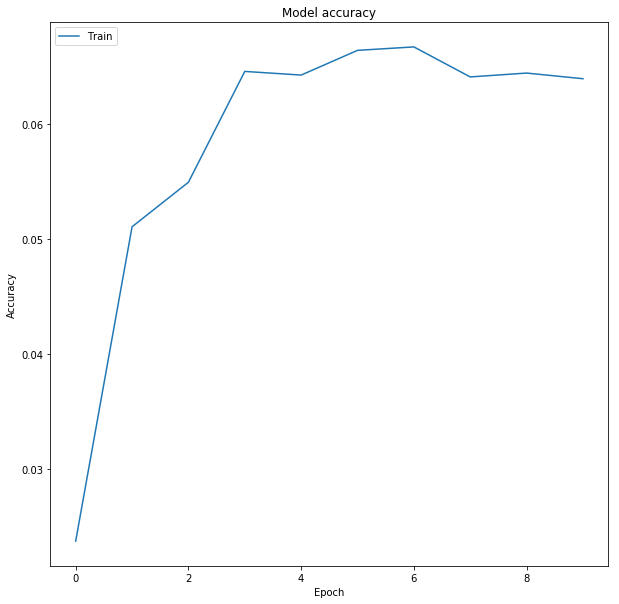

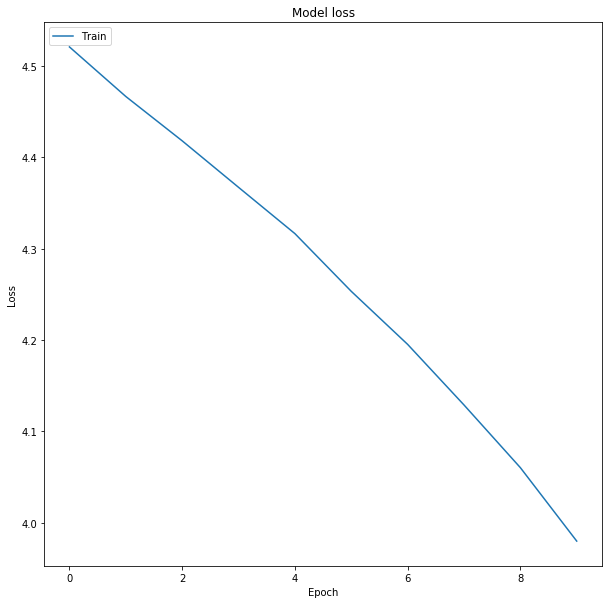

In [62]:
# Plot training accuracy values
plt.plot(history1.history['categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history1.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

## Training with generators

Reading the whole data set into memory is not always possible. There are different possibilities to that problem, one is to use the Dataset classes in the tensorflow backend. We will look at that a bit more in the next lecture. The other possibility is to use *generators* from python. A generator function to use for keras will generate a batch of data at the time. 

In [15]:
def batch_generator(batch_size, height: int, width: int):
    while True:
        yield image_batch, label_batch

In order to use the generator, we use the ```model.fit_generator``` function. 

In [16]:
PATCH_HEIGHT = 128
PATCH_WIDTH = 128
BATCH_SIZE = 100
EPOCHS = 10
STEPS_PER_EPOCHS = 20
model = fcn_no_border(PATCH_HEIGHT, PATCH_WIDTH)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history2 = model.fit_generator(
        generator=batch_generator(BATCH_SIZE, PATCH_HEIGHT, PATCH_WIDTH),
        epochs=EPOCHS,
        verbose=1,
        steps_per_epoch=STEPS_PER_EPOCHS,
        shuffle=False,
        callbacks=None)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
20/20 [==============================] - 42s 2s/step - loss: 4.3063 - categorical_accuracy: 0.0596
Epoch 2/10
20/20 [==============================] - 44s 2s/step - loss: 3.6140 - categorical_accuracy: 0.0707
Epoch 3/10
20/20 [==============================] - 45s 2s/step - loss: 3.1310 - categorical_accuracy: 0.0791
Epoch 4/10
20/20 [==============================] - 39s 2s/step - loss: 2.9072 - categorical_accuracy: 0.1030
Epoch 5/10
20/20 [==============================] - 38s 2s/step - loss: 2.7405 - categorical_accuracy: 0.1490
Epoch 6/10
20/20 [==============================] - 41s 2s/step - loss: 2.5837 - categorical_accuracy: 0.1771
Epoch 7/10
20/20 [==============================] - 35s 2s/step - loss: 2.4606 - categorical_accuracy: 0.2063
Epoch 8/10
20/20 [==============================] - 39s 2s/step - loss: 2.3662 - categorical_accuracy: 0

## Plot training

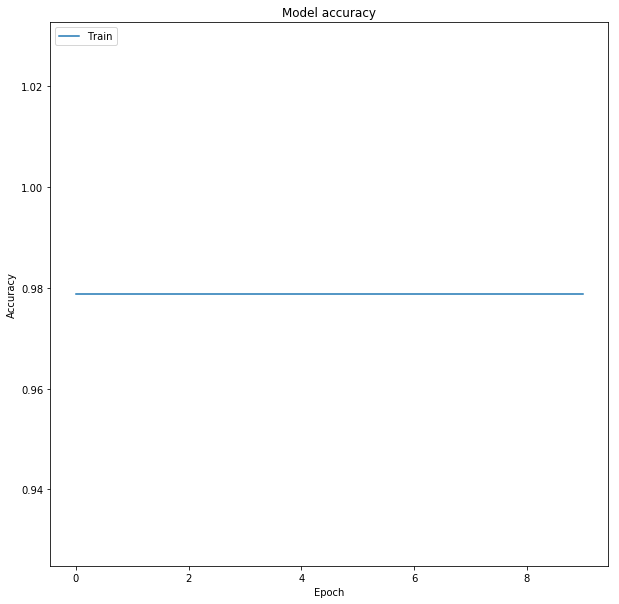

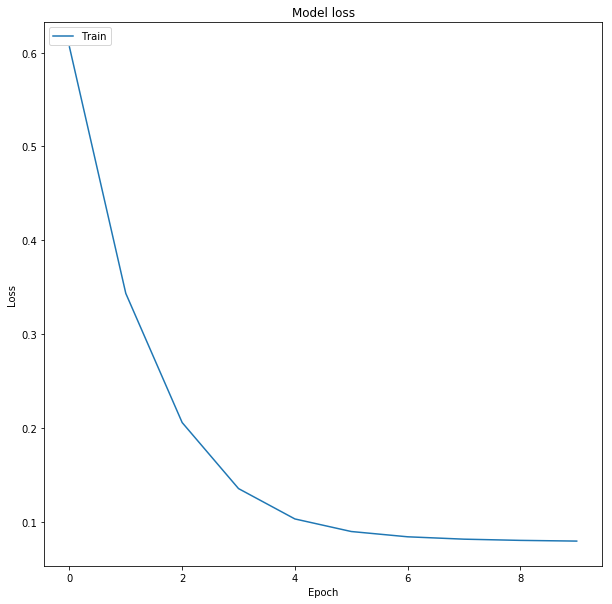

In [65]:
# Plot training accuracy values
plt.plot(history2.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

## Test model

mean: 0.4641532301902771
mask: 1.0


NameError: name 'model' is not defined

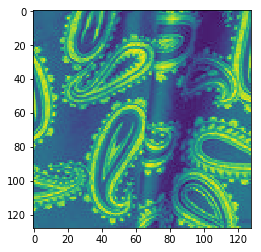

In [8]:
image, label = load_test_batch(1)
print('mean: {}'.format(np.mean(image)))
print('mask: {}'.format(np.max(label)))

plt.imshow(image.reshape((128, 128)))

pred = model.predict(image.reshape(1,128,128,1))
print(pred.shape, pred[0][200])  # the (1,...) is neglected as a dimension

print('min, max, mean: {},{}, {}'.format(np.min(image_batch), np.max(image_batch), np.mean(image_batch)))

print("Random approach accuracy: 0.02127659574")

## Exercise 1: Categorical data

In the example above we had only two classes, but in most applications we want to classify into more classes, as you have for example already done in the first homework, when classifying number.

Change the network and the generation of examples to use 5 classes.

In [ ]:
#changed in the code above

## Exercise 2: Padding

Also in the example, we used padding for the convolutional filters by specifying ```padding='same'```. However this will not process the data at the edges correctly as the missing data will be filled with 0. For training it is preferable to use only the data that fits inside the convolutional filters. This can be specified using ```padding='valid'```. However then the labels will have to be resized accordingly.

Change the network to use *valid* padding.

## Exercise 3: Data preparation for homework 2

In the homework, you should train a network to recognise different texture categories from the describable texture data base. If you have already downloaded the data and/or extracted it, copy it to the current folder for this exercise (otherwise it will download again). The following function will download and prepare the dataset by converting it to grayscale, extract a smaller region in the center and renaming the files consecutively. It will also divide the data into 3 sets for training, validation and testing. 

In [ ]:
from dtd_loader import *

In [ ]:
download_and_convert()